Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
3/3 [==============================] - 0s 19ms/step - loss: 103.5080
Epoch 2/1000
3/3 [==============================] - 0s 2ms/step - loss: 96.4081
Epoch 3/1000
3/3 [==============================] - 0s 3ms/step - loss: 89.4202
Epoch 4/1000
3/3 [==============================] - 0s 2ms/step - loss: 82.03

3/3 [==============================] - 0s 2ms/step - loss: 54.9846
Epoch 93/1000
3/3 [==============================] - 0s 2ms/step - loss: 54.9648
Epoch 94/1000
3/3 [==============================] - 0s 2ms/step - loss: 54.9109
Epoch 95/1000
3/3 [==============================] - 0s 2ms/step - loss: 54.8664
Epoch 96/1000
3/3 [==============================] - 0s 2ms/step - loss: 54.8339
Epoch 97/1000
3/3 [==============================] - 0s 2ms/step - loss: 54.7706
Epoch 98/1000
3/3 [==============================] - 0s 2ms/step - loss: 54.7315
Epoch 99/1000
3/3 [==============================] - 0s 2ms/step - loss: 54.7046
Epoch 100/1000
3/3 [==============================] - 0s 1ms/step - loss: 54.6803
Epoch 101/1000
3/3 [==============================] - 0s 2ms/step - loss: 54.6357
Epoch 102/1000
3/3 [==============================] - 0s 2ms/step - loss: 54.6230
Epoch 103/1000
3/3 [==============================] - 0s 2ms/step - loss: 54.6598
Epoch 104/1000
3/3 [==================

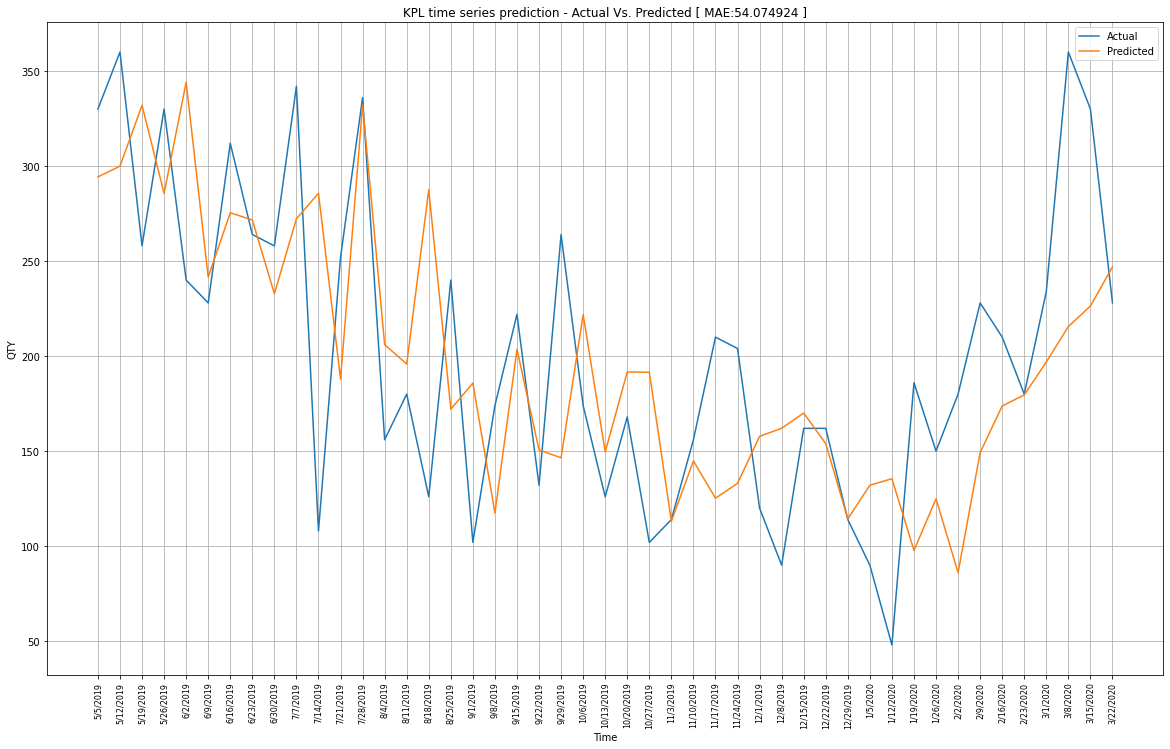

In [209]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(20, 8))
    plt.xticks(rotation=90, size=8)
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()
time_step = []
qty = []
with open('Mean_WEEK-WISE_FGAS-660A-16-00087B4covid.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for i in reader:
    qty.append(int(i[1]))
    time_step.append((i[0]))
series = np.array(qty)
time = np.array(time_step)
# plot_series(time, series)
# split_time = int(1 * len(series))
# time_train = time[:split_time]
# x_train = series[:split_time]
# time_valid = time[split_time:]
# x_valid = series[split_time:]
time_train = time
x_train = series
window_size = 4
batch_size = 21
shuffle_buffer_size = 55
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# relu | LeakyReLU | gelu | elu | selu | swish
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, input_shape=[window_size], activation="LeakyReLU"),
    tf.keras.layers.Dense(4, activation="LeakyReLU"),
    tf.keras.layers.Dense(1, activation="LeakyReLU")
])
print(model.summary())
# opt adam | adagrad | Adadelta | RMSprop | SGD | momntum | NAG |
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model.compile(loss="mae", optimizer='adam')
model.fit(dataset, epochs=1000, callbacks=[callback], verbose=1)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
# # patience: Number of epochs with no improvement after which training will be stopped.
# # # LR
# history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
# plt.semilogx(history.history["lr"], history.history["loss"])
# # plt.axis([1e-8, 1e-4, 0, 800])
# plt.show()
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
# forecast = forecast[:]
results = np.array(forecast)[:,0,0]
# results = np.roll(results, +5)
# results = results[:]
# print('forecast:\n', forecast)
# print('results:\n', results)
time_train = time_train[4:]
x_train = x_train[4:]
MAE = tf.keras.metrics.mean_absolute_error(x_train, results).numpy()
print('MAE: ', MAE)
plt.figure(figsize=(20, 12))
plt.plot(time_train, x_train, label='Actual')
plt.plot(time_train,results, label='Predicted')
plt.title('KPL time series prediction - Actual Vs. Predicted [ MAE:'+str(MAE)+" ]")
plt.xlabel("Time")
plt.ylabel("QTY")
plt.xticks(rotation=90, size=8)
plt.legend(loc='upper right')
plt.grid(True)
# plt.savefig('adagrad LeakyReLU b 45 img.jpg')
plt.show()

In [210]:
# forecast for next 10 days
n_features = 4
# results = results
results = results.astype(int)
print(results)
print(len(results))
# demonstrate prediction for next 10 days
x_input = np.array(results)[42:]
temp_input = list(x_input)
lst_output = []
i = 0
while i < 4:
    if len(temp_input) > 4:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_features))
#         x_input = x_input.flatten()
        # forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
        yhat = model.predict(x_input)
        print("{} day output {}".format(i, yhat))
        temp_input.append(yhat[0][0])
        temp_input = temp_input[1:]
        lst_output.append(yhat[0][0])
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i = i + 1

print(lst_output)
forecast = pd.DataFrame(lst_output)
# result.to_csv('RMSprop LeakyReLU output for next 4 weeks.csv')

# Visualizing The Output
# # pred = np.arange(771, 776)
# F = np.arange(776, 781)
# # print(pred)

# results = results[0:]
# print(results)
# lst_output = np.array(lst_output)
# lst_output = lst_output.astype(int)
# print(F)
# print(lst_output)

# # plt.plot(pred, results)
# plt.plot(F, lst_output)
# lst_output = pd.DataFrame(lst_output)
# lst_output.to_csv('prednew.csv')
# plt.show()

[294 299 331 285 344 241 275 271 232 272 285 187 332 206 195 287 172 185
 117 203 150 146 221 149 191 191 113 144 125 133 157 162 170 153 114 132
 135  97 124  86 149 173 179 196 215 226 246]
47
0 day input [196 215 226 246]
0 day output [[214.11046]]
1 day input [215.         226.         246.         214.11045837]
1 day output [[210.98236]]
2 day input [226.         246.         214.11045837 210.98236084]
2 day output [[220.8349]]
3 day input [246.         214.11045837 210.98236084 220.8348999 ]
3 day output [[208.66052]]
[214.11046, 210.98236, 220.8349, 208.66052]


In [211]:
forecast.columns = ['Predicted']

In [212]:
# time_train = pd.DataFrame(time_train, columns=['DATE'])
# print('time_train:\n', time_train.tail())
# print('len^:', len(time_train))


In [213]:
# time_train.loc[time_train.index[-1], 'DATE']

In [214]:
# future_dates = pd.date_range(start = '03/10/2020', periods=4, freq = 'W-SUN')
time_d = pd.date_range(start = '05/05/2019', periods=51, freq = 'W-SUN')
# future_dates = future_dates.astype(str)
# time_train = time_train.astype(str)
x_train, results, lst_output


(array([330, 360, 258, 330, 240, 228, 312, 264, 258, 342, 108, 252, 336,
        156, 180, 126, 240, 102, 174, 222, 132, 264, 174, 126, 168, 102,
        114, 156, 210, 204, 120,  90, 162, 162, 114,  90,  48, 186, 150,
        180, 228, 210, 180, 234, 360, 330, 228]),
 array([294, 299, 331, 285, 344, 241, 275, 271, 232, 272, 285, 187, 332,
        206, 195, 287, 172, 185, 117, 203, 150, 146, 221, 149, 191, 191,
        113, 144, 125, 133, 157, 162, 170, 153, 114, 132, 135,  97, 124,
         86, 149, 173, 179, 196, 215, 226, 246]),
 [214.11046, 210.98236, 220.8349, 208.66052])

In [215]:
fc = results
fc

array([294, 299, 331, 285, 344, 241, 275, 271, 232, 272, 285, 187, 332,
       206, 195, 287, 172, 185, 117, 203, 150, 146, 221, 149, 191, 191,
       113, 144, 125, 133, 157, 162, 170, 153, 114, 132, 135,  97, 124,
        86, 149, 173, 179, 196, 215, 226, 246])

In [216]:

fc = np.concatenate((fc, lst_output))
fc = pd.DataFrame(fc, columns=['Pred'])
time_d = pd.DataFrame(time_d, columns=['Date'])
x_train= pd.DataFrame(x_train, columns=['Org'])

cc= pd.concat([time_d,x_train, fc],axis=1)
# cc['Org'] = cc.Org.fillna(0)
cc

,Date,Org,Pred
0,2019-05-05,330.0,294.000000
1,2019-05-12,360.0,299.000000
2,2019-05-19,258.0,331.000000
3,2019-05-26,330.0,285.000000
4,2019-06-02,240.0,344.000000
5,2019-06-09,228.0,241.000000
6,2019-06-16,312.0,275.000000
7,2019-06-23,264.0,271.000000
8,2019-06-30,258.0,232.000000
9,2019-07-07,342.0,272.000000


In [217]:
# plt.rcParams["figure.figsize"] = (20,10)

# plt.plot(fc[47], 'k-', label = 'Historical data (today + last 47 weeks)')
# plt.plot((fc[47:]), 'g-', label = 'To be predicted (next 4 weeks)')
# plt.axvline(x=46, c = 'r')
# plt.plot(fc[47], 'rx', markersize = 20, label = "Today")
# # plt.xticks(range(0, 97))
# plt.title('Training data with labels')
# plt.xlabel('Days')
# plt.ylabel('Original QTY')
# plt.ion()
# plt.legend()
# plt.show()

In [218]:
# df_date = pd.DataFrame(future_dates)
# df_date.columns =['Future Dates']
# df_date

In [219]:
# concat = pd.concat([df_date, result], axis=1)

In [220]:
# concat

In [221]:
# time_train

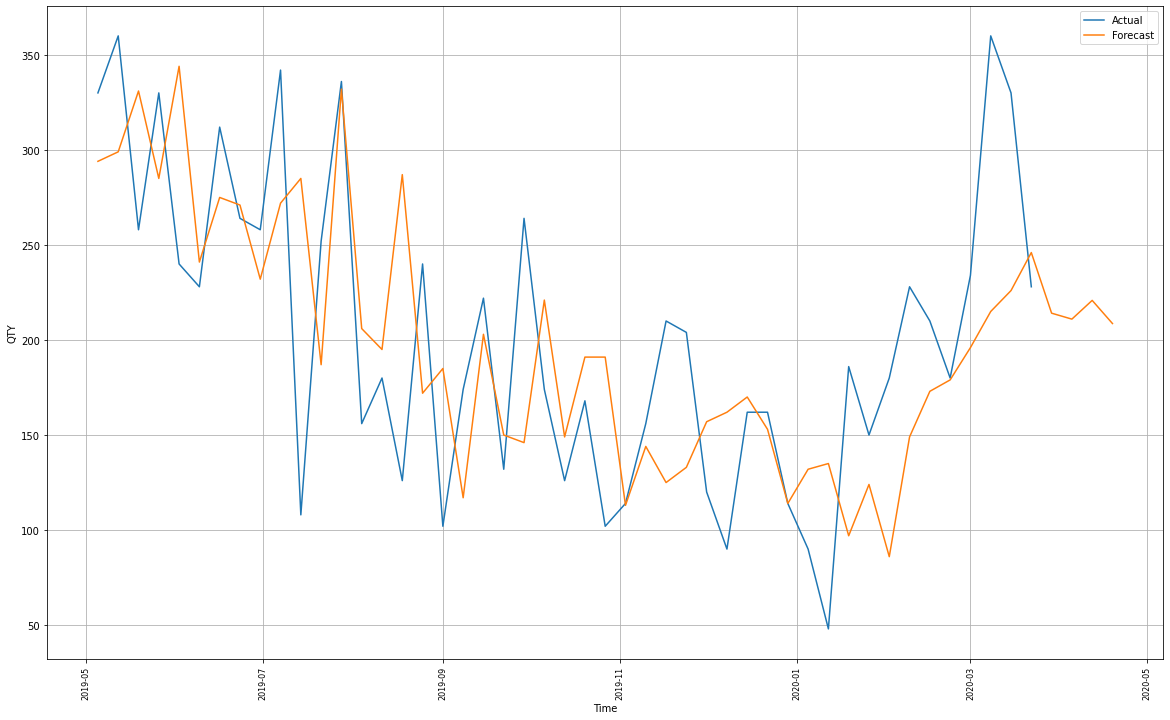

In [222]:
# time_train = time_train[4:]
# x_train = x_train[4:]
# MAE = tf.keras.metrics.mean_absolute_error(x_train, results).numpy()
# print('MAE: ', MAE)
plt.figure(figsize=(20, 12))
plt.plot(cc['Date'],cc['Org'], label='Actual')
plt.plot(cc['Date'],cc['Pred'], label='Forecast')
# plt.plot(concat, label='Forecast')
# plt.title('KPL time series prediction - Actual Vs. Predicted [ MAE:'+str(MAE)+" ]")
plt.xlabel("Time")
plt.ylabel("QTY")
plt.xticks(rotation=90, size=8)
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('forecasted_img1.jpg')
plt.show()

In [ ]:
# plt.rcParams["figure.figsize"] = (20,10)

# plt.plot(fc[47], 'k-', label = 'Historical data (today + last 47 weeks)')
# plt.plot((fc[47:]), 'g-', label = 'To be predicted (next 4 weeks)')
# plt.axvline(x=46, c = 'r')
# plt.plot(fc[47], 'rx', markersize = 20, label = "Today")
# # plt.xticks(range(0, 97))
# plt.title('Training data with labels')
# plt.xlabel('Days')
# plt.ylabel('Original QTY')
# plt.ion()
# plt.legend()
# plt.show()